In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [3]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 5

#log spaced array of values

macro_configs = config_generator(g=[9, 3, 6, 9],
                                 gamma=[0.99, 0.1, 0.3, 0.5],
                                 alpha=[0.5, 1])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [4]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = params['g']
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [5]:
#Set tasks
R = 2
gamma = params['gamma']
alpha = params['alpha']
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance_block_haar(R=R,
                                                                                            gamma=gamma,
                                                                                            report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)

0


In [9]:
# R = 1 test #
#Set tasks
if True:

    R = 2
    gamma = params['gamma']
    alpha = params['alpha']
    N_tasks = int(alpha * N)
    #PR_D = params['PR_D']
    PR_D = 1
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction
    sigma_mn_all = np.zeros((R, R, N_tasks))
    #C_sigma = params['C_sigma']
    total_attempts = 0
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=gamma,
                                                                                     sigma_off=gamma,
                                                                                     symmetry_factor=0,
                                                                                     traceless=False, report_attempts=True)
        total_attempts += n_attempts
    print(total_attempts)

5098


In [18]:
def get_C_element(C_ij):
    sigmoid = lambda x: 1/(1+np.exp(-x))
    def generate_rho(rho_1, rho_2, f_transition, N_tasks):
        return rho_1 + (rho_2 - rho_1) * sigmoid(16*(np.arange(N_tasks)/N_tasks - f_transition))
    from scipy.optimize import minimize
    def objective(t_flip, D):
        a_values = np.arange(len(D))
        t_values = a_values / len(D)
        unscaled_rho_values = 1 - 2 / (1 + np.exp(-16 * (t_values - t_flip)))
        return np.sum(D * unscaled_rho_values)**2
    objective_ = lambda t: objective(t, D)
    result = minimize(objective_, 0.5, method='BFGS')
    optimal_t_flip = result.x[0]
    rho = generate_rho(C_ij, -C_ij, optimal_t_flip, N_tasks)
    return rho

In [19]:
C_11 = get_C_element(gamma)
C_12 = get_C_element(gamma)
C_21 = get_C_element(-gamma)
C_22 = get_C_element(gamma)

In [20]:
sigma_mn_all = np.zeros((R, R, N_tasks))
sigma_mn_all[0,0,:] = C_11
sigma_mn_all[0,1,:] = C_12
sigma_mn_all[1,0,:] = C_21
sigma_mn_all[1,1,:] = C_22

In [21]:
### --- Estimate C empirically --- ###

#lags window
T_window_emp = 120
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

compute_empirical_psi = True
if compute_empirical_psi:
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
    C_emp = 0
    N_runs = 2
    for i_run in range(N_runs):
        x, r = sample_activity(T_sim=4000, dt_save=dT_emp, dt=0.05, W=W_, phi_torch=phi_torch,
                               runga_kutta=True, T_save_delay=200)
        r = torch.from_numpy(r).type(torch.FloatTensor).to(0)[:,None,:]
        C_emp_ = compute_lagged_xcov(r, r, lags_emp, dt_save=dT_emp)

        #symmetrize C_emp for comparison
        C_emp_ = C_emp_.cpu().detach().numpy().squeeze().mean(-1)
        C_emp += C_emp_/N_runs
    #C_emp = np.concatenate([C_emp[-n_lags_emp:][::-1], C_emp[1:n_lags_emp]])
    #lags_emp_full = np.concatenate([-lags_emp[-n_lags_emp:][::-1], lags_emp[1:n_lags_emp]])
else:
    lags_emp_full = np.concatenate([-lags_emp[-n_lags_emp:][::-1], lags_emp[1:n_lags_emp]])
    C_emp = np.zeros_like(lags_emp_full)

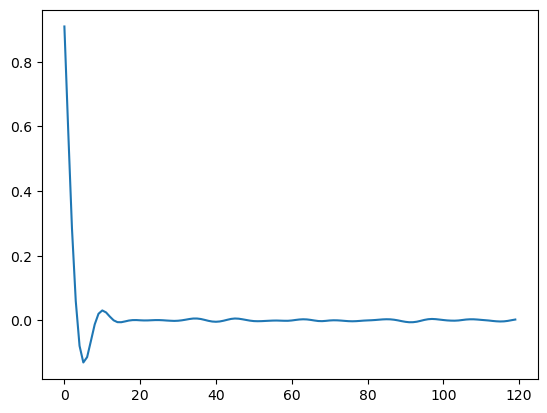

In [22]:
plt.plot(C_emp)

In [6]:
#theory parameters
T_window = 120
dT = 0.05

In [24]:
#R = 1 test #
if True:
    sigma_mn_all_flat = np.vstack(sigma_mn_all)
    N_samples = 5000
    num_iter = 200
    final_avg_iter = 40
    #run DMFT solver loop
    C_dmft, S_dmft = util.solve_dmft(
        update_fn=(lambda C, S:
                   update_extensive_tasks_general(torch.tensor(D).to(0),
                                                  torch.tensor(sigma_mn_all_flat).to(0),
                                                  C, S, N_samples=N_samples,
                                                  dt=dT, alpha=alpha)),
        callback_fn=None,
        init_dt=dT,
        N_t=int((2*T_window)/dT),
        num_iter=num_iter,
        device=0,
        alpha=0.8,
        final_avg_iter=final_avg_iter,
        verbose=True)
#plt.xlim([0, 2000])

Iteration 1/200
Iteration 2/200
Iteration 3/200
Iteration 4/200
Iteration 5/200
Iteration 6/200
Iteration 7/200
Iteration 8/200
Iteration 9/200
Iteration 10/200
Iteration 11/200
Iteration 12/200
Iteration 13/200
Iteration 14/200
Iteration 15/200
Iteration 16/200
Iteration 17/200
Iteration 18/200
Iteration 19/200
Iteration 20/200
Iteration 21/200
Iteration 22/200
Iteration 23/200
Iteration 24/200
Iteration 25/200
Iteration 26/200
Iteration 27/200
Iteration 28/200
Iteration 29/200
Iteration 30/200
Iteration 31/200
Iteration 32/200
Iteration 33/200
Iteration 34/200
Iteration 35/200
Iteration 36/200
Iteration 37/200
Iteration 38/200
Iteration 39/200
Iteration 40/200
Iteration 41/200
Iteration 42/200
Iteration 43/200
Iteration 44/200
Iteration 45/200
Iteration 46/200
Iteration 47/200
Iteration 48/200
Iteration 49/200
Iteration 50/200
Iteration 51/200
Iteration 52/200
Iteration 53/200
Iteration 54/200
Iteration 55/200
Iteration 56/200
Iteration 57/200
Iteration 58/200
Iteration 59/200
Iterat

In [7]:
if True:

    diff = 1
    avg_gains = [compute_phi_prime_avg(g**2)]
    while diff > 1e-5:
        leak = 1 - gamma**2 * (avg_gains[-1] * g)**2 / (alpha * R)
        #from pdb import set_trace
        #set_trace()
        if leak < 0:
            avg_gains[-1] *= 0.95
            continue
        d = compute_Delta_0(g=g, leak=leak)
        avg_gain = compute_phi_prime_avg(d)
        avg_gains.append(avg_gain)
        diff = np.abs(avg_gains[-1] - avg_gains[-2])
    avg_gain = avg_gains[-1]
    leak = 1 - gamma**2 * (avg_gain * g)**2 / (alpha * R)
    d = compute_Delta_0(g=g, leak=leak)
    time, Delta_T = integrate_potential(d, g=g, leak=leak, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_phi_half = compute_C_simple(d, Delta_T)

    C_phi = np.concatenate([C_phi_half,
                            np.array([C_phi_half[-1]]),
                            C_phi_half[1:][::-1]])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi_omega = avg_gain/((1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi_omega, S_phi_omega)

In [102]:
if True:
    ### --- Compute Psi from theory --- ###

    C_phi = C_dmft.cpu().numpy()
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(-T//2, 0), np.arange(0, T//2)])
    C_phi_omega = fft(C_phi, dT)
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)

    S_phi = np.sqrt(2*np.pi)*S_dmft.cpu().numpy()
    S_phi_omega = fft(S_phi, dT)
    S_phi_S_phi = np.multiply.outer(S_phi_omega, S_phi_omega)

In [83]:
C_match_error = np.sum(np.square(C_emp - C_phi[:int(T_window_emp/dT):int(dT_emp/dT)]))

In [ ]:
u = 0
v = 0
w = 0
x_12 = 0
samples = list(range(0, N_tasks, 10))
measure = 1/len(samples)
d = D[0]
for i_sample in samples:
    if i_sample % 20 == 0:
        print(i_sample)
    C = sigma_mn_all[:,:,i_sample]
    CT = C.T
    M_omega = np.linalg.inv(np.eye(R)[None,:,:] - d*S_phi_omega[:,None,None]*CT[None,:,:])
    M_omegaT = np.swapaxes(M_omega, 1, 2)
    #print(np.amax(np.linalg.cond(M_omega)))
    u += alpha/R * d**2 * np.einsum('vrs, wrs -> vw', M_omega, M_omega) * measure
    #u += alpha * d**2 * np.einsum('vrs, wsr -> vw', M_omega, M_omega) * measure
    MM_omega = np.einsum('vrs, vst -> vrt', M_omega, np.conj(M_omegaT))
    v += alpha/R * d**4 * np.einsum('vrs, wrs -> vw', MM_omega, MM_omega) * measure
    CT_M_omega = np.einsum('rs, vst -> vrt', CT, M_omega)
    C_M_omega = np.einsum('rs, vst -> vrt', C, np.conj(M_omegaT))
    w += alpha/R * d**2 * np.einsum('vrs, wsr -> vw', CT_M_omega, C_M_omega) * measure
    MTM_omega = np.einsum('vrs, vst -> vrt', np.conj(M_omegaT), M_omega)
    x_12 += alpha/R * d**3 * np.einsum('vrs, wrs -> vw', np.swapaxes(np.conj(C_M_omega), 1, 2), MTM_omega) * measure
    #CT_Mdagger = np.einsum('rs, vst -> vrt', C, np.conj(M_omegaT))        # C^T M†
    #CT_Mdagger = np.einsum('rs, vst -> vrt', CT, np.conj(M_omegaT))        # C^T M†
    #CT_Mdagger_M = np.einsum('vrs, vst -> vrt', CT_Mdagger, M_omega)       # C^T M† M
    #x_12 += alpha * d**3 * np.einsum('vrs, wrs -> vw', M_omega, CT_Mdagger_M) * measure

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040


In [31]:
x_tilde_12 = x_12 * S_phi_omega[:,None] * (np.abs(S_phi_omega)**2)[None,:]
w_tilde = w * np.multiply.outer(np.conj(S_phi_omega), S_phi_omega)
xxw = (1 + x_tilde_12) * (1 + np.conj(x_tilde_12.T)) / (1 - np.conj(w_tilde))

M = (v * np.abs(S_phi_S_phi)**2 - 1 + xxw + np.conj(xxw)) / (np.abs(1 - u * S_phi_S_phi)**2)
Psi_omega1_omega2 = M * C_phi_C_phi
Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)

In [32]:
dim_r_theory = C_phi[0]**2/Psi_tau1_tau2[0,0].real

In [93]:
D_changed = D.copy()

In [94]:
compute_empirical = True
if compute_empirical:
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
    x_cov, r_cov = estimate_cov_eigs(T_sim=3000, dt_save=1, dt=0.05, W=W_, phi_torch=phi_torch,
                                     T_save_delay=500, N_batch=1, N_loops=5,
                                     return_raw_covs=True, runga_kutta=True)

    dim_r_emp = np.trace(r_cov)**2 / (r_cov**2).sum() / N
    dim_x_emp = np.trace(x_cov)**2 / (x_cov**2).sum() / N
else:
    dim_r_emp = 0

In [163]:
#C_match_error = 0
processed_data = np.array([dim_r_emp, dim_r_theory, C_match_error])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [12]:
###Truncate file above
file_name = 'Figure_6_dimensionality_spontaneous_check'
job_name = 'check_R2_non_haar_2'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook Figure_6_dimensionality_spontaneous_check.ipynb to script
[NbConvertApp] Writing 62336 bytes to Figure_6_dimensionality_spontaneous_check.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b3c3c309d10> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b3c3c309d10> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [13]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='Multi_Task_Elife')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='Multi_Task_Elife', lkumar=True)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/Multi_Task_Elife/check_R2_non_haar_2/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/condensed_tasks.py
mft-theory/LDR_dim/extensive_tasks.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
m

In [1]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4895853    lkumar  jupyter   om2382  R       4:10      1 ax15


In [40]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'r_dim_spontaneous_fixed'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

In [3]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'CT_transpose_check'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

In [3]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'check_R2_non_haar_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='Multi_Task_Elife')

(array([30., 22., 19.,  9.,  3.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.0003889 , 0.00148966, 0.00259042, 0.00369118, 0.00479194,
        0.0058927 , 0.00699345, 0.00809421, 0.00919497, 0.01029573,
        0.01139649, 0.01249725, 0.01359801, 0.01469876, 0.01579952,
        0.01690028, 0.01800104, 0.0191018 , 0.02020256, 0.02130332,
        0.02240407]),
 <BarContainer object of 20 artists>)

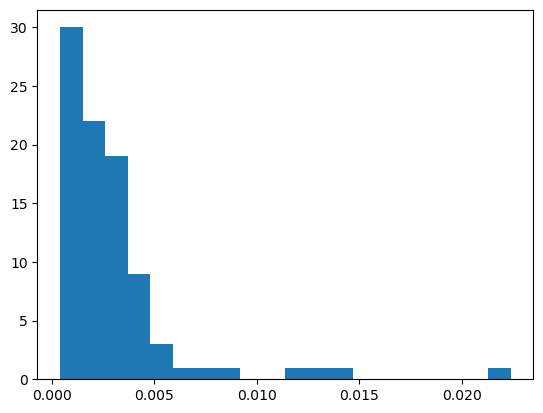

In [4]:
plt.hist(theory_results[1][:,:,:,:,2].flatten(), bins=20)

In [5]:
theory_results[0]

{'g': [3, 6, 9],
 'gamma': [0.1, 0.3, 0.5],
 'alpha': [0.5, 1],
 'i_seed': [0, 1, 2, 3, 4]}

Text(0.5, 0, '$g_\\mathrm{eff}$')

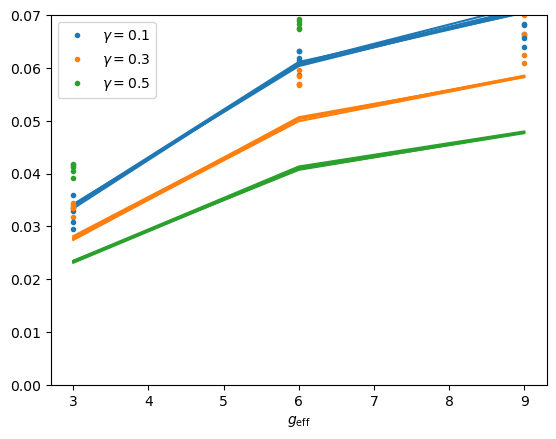

In [6]:
g_values = theory_results[0]['g']
for i_seed in range(5):
    for i_gamma in range(3):
        plt.plot(g_values, theory_results[1][:,i_gamma,1,i_seed,0], '.', color='C{}'.format(i_gamma))
        plt.plot(g_values, theory_results[1][:,i_gamma,1,i_seed,1], color='C{}'.format(i_gamma), label='_nolegend_')
plt.ylim([0, 0.07])
plt.legend(['$\gamma = {}$'.format(theory_results[0]['gamma'][i]) for i in range(3)])
plt.xlabel('$g_\mathrm{eff}$')

Text(0.5, 0, '$g_\\mathrm{eff}$')

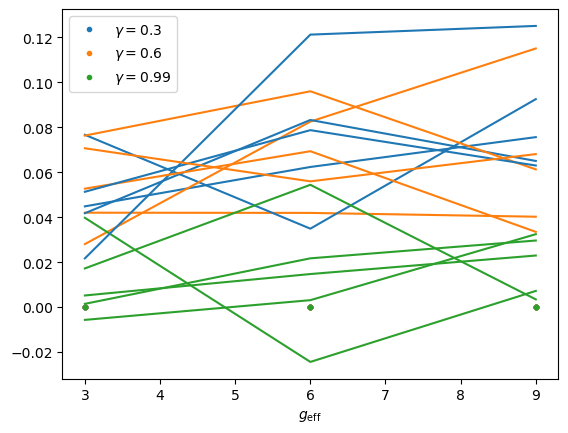

In [41]:
g_values = theory_results[0]['g']
for i_seed in range(5):
    for i_gamma in range(3):
        plt.plot(g_values, theory_results[1][:,i_gamma,0,i_seed,0], '.', color='C{}'.format(i_gamma))
        plt.plot(g_values, theory_results[1][:,i_gamma,0,i_seed,1], color='C{}'.format(i_gamma), label='_nolegend_')
#plt.ylim([0, 0.04])
plt.legend(['$\gamma = {}$'.format(theory_results[0]['gamma'][i]) for i in range(3)])
plt.xlabel('$g_\mathrm{eff}$')

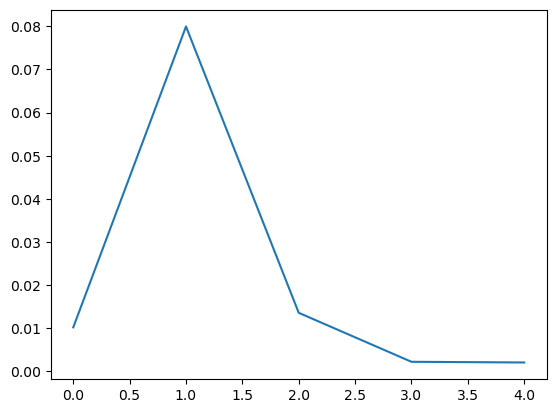

In [17]:
plt.plot(theory_results[1][2,2,1,:,2])

(array([75., 10.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([4.06342711e-04, 2.34199335e-02, 4.64335242e-02, 6.94471150e-02,
        9.24607057e-02, 1.15474296e-01, 1.38487887e-01, 1.61501478e-01,
        1.84515069e-01, 2.07528660e-01, 2.30542250e-01, 2.53555841e-01,
        2.76569432e-01, 2.99583023e-01, 3.22596613e-01, 3.45610204e-01,
        3.68623795e-01, 3.91637386e-01, 4.14650976e-01, 4.37664567e-01,
        4.60678158e-01]),
 <BarContainer object of 20 artists>)

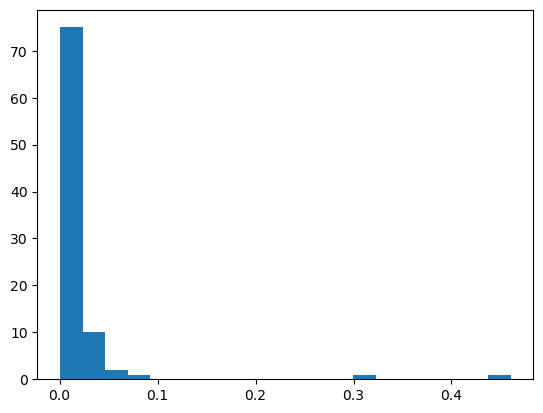

In [6]:
plt.hist(theory_results[1][:,:,:,:,2].flatten(), bins=20)

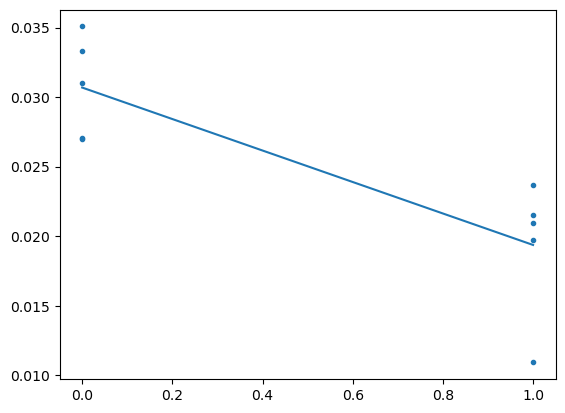

In [45]:
i_N = 0
i_g = 1
i_gamma = 0
for i_seed in range(5):
    plt.plot(sim_results[1][i_N,i_g,:,i_seed,0], '.', color='C0')
    plt.plot(theory_results[1][i_g,:,i_seed,1], color='C1')
plt.plot(sim_results[1][i_N,i_g,:,:,0].mean(1), color='C0')

In [48]:
print(theory_results[1][1,:,:,1].mean(1))
print(sim_results[1][0,1,:,:,0].mean(1))

[0.01977244        nan]
[0.03068903 0.0193701 ]


In [68]:
theory_results[1][0,1,0,0]/4000

0.019617811267504927

In [79]:
theory_results[1][0,:,:,0]/4000

array([[0.03057672, 0.0281692 , 0.02593196, 0.03030844, 0.0269989 ],
       [0.01961781, 0.02078374, 0.02881175, 0.01705006, 0.01765112]])

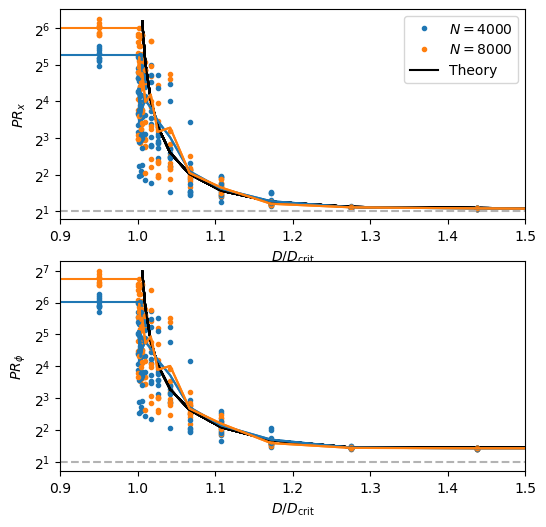

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
i_g = 0

for i in range(2):
    ax[0].plot(theory_results[0]['D_crit_factor'][1:],theory_results[1][i,1:,i_g,i_seed,0],
             '.', alpha=1, color='C{}'.format(i))
ax[0].plot(theory_results[0]['D_crit_factor'][5:],theory_results[1][i,5:,i_g,i_seed,1],
         alpha=1, color='k')

for i_seed in range(10):
    for i in range(2):
        ax[0].plot(theory_results[0]['D_crit_factor'][1:],theory_results[1][i,1:,i_g,i_seed,0],
                 '.', alpha=1, color='C{}'.format(i))
        ax[0].plot(theory_results[0]['D_crit_factor'][5:],theory_results[1][i,5:,i_g,i_seed,1],
                 alpha=1, color='k')
        ax[1].plot(theory_results[0]['D_crit_factor'][1:],theory_results[1][i,1:,i_g,i_seed,2],
                 '.', alpha=1, color='C{}'.format(i))
        ax[1].plot(theory_results[0]['D_crit_factor'][5:],theory_results[1][i,5:,i_g,i_seed,3],
                 alpha=1, color='k')
for i in range(2):
    for i_ax in range(2):
        ax[i_ax].plot(theory_results[0]['D_crit_factor'][1:],theory_results[1][i,1:,i_g,:,2*i_ax].mean(-1),
                 alpha=1, color='C{}'.format(i))
        ax[i_ax].plot(theory_results[0]['D_crit_factor'][1:],theory_results[1][i,1:,i_g,:,2*i_ax].mean(-1),
                 alpha=1, color='C{}'.format(i))

for i_ax in range(2):
    for i in range(2):
        ax[i_ax].plot([0.95]*10,theory_results[1][i,0,i_g,:,2*i_ax], '.')

for i_ax in range(2):
    for i in range(2):
        ax[i_ax].set_xlim([0.9, 1.5])
        ax[i_ax].hlines(y=theory_results[1][i,0,i_g,:,2*i_ax].mean(), color='C{}'.format(i), xmin=0.9, xmax=1)
#plt.yscale('log', base=2)
#ax[0].set_xticks(theory_results[0]['D_crit_factor'][::2])
#ax[1].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[0].set_xlabel('$D/D_\mathrm{crit}$')
ax[1].set_xlabel('$D/D_\mathrm{crit}$')
ax[0].set_ylabel('$PR_x$')
ax[1].set_ylabel('$PR_\phi$')
ax[0].legend(['$N = 4000$', '$N = 8000$', 'Theory'])
ax[0].set_yscale('log', base=2)
ax[1].set_yscale('log', base=2)
ax[0].axhline(y=2, linestyle='--', color=('0.7'))
ax[1].axhline(y=2, linestyle='--', color=('0.7'))
#ax[1].set_xscale('log', base=2)

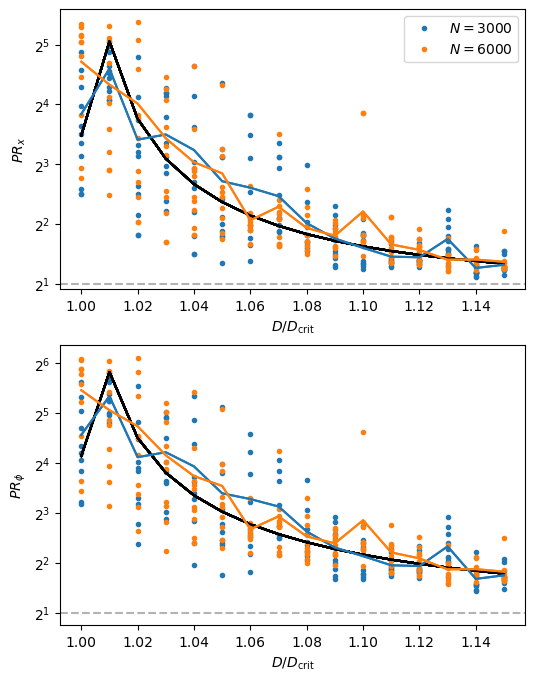

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

for i in range(2):
    ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,0,0],
             '.', alpha=1, color='C{}'.format(i))
for i in range(2):
    for i_seed in range(10):
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,0],
                 '.', alpha=1, color='C{}'.format(i))
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,1],
                 alpha=1, color='k')
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,2],
                 '.', alpha=1, color='C{}'.format(i))
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,3],
                 alpha=1, color='k')
for i in range(2):
    for i_ax in range(2):
        ax[i_ax].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,:,2*i_ax].mean(-1),
                 alpha=1, color='C{}'.format(i))
        ax[i_ax].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,:,2*i_ax].mean(-1),
                 alpha=1, color='C{}'.format(i))
#plt.yscale('log', base=2)
ax[0].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[1].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[0].set_xlabel('$D/D_\mathrm{crit}$')
ax[1].set_xlabel('$D/D_\mathrm{crit}$')
ax[0].set_ylabel('$PR_x$')
ax[1].set_ylabel('$PR_\phi$')
ax[0].legend(['$N = 3000$', '$N = 6000$'])
ax[0].set_yscale('log', base=2)
ax[1].set_yscale('log', base=2)
ax[0].axhline(y=2, linestyle='--', color=('0.7'))
ax[1].axhline(y=2, linestyle='--', color=('0.7'))
#ax[1].set_xscale('log', base=2)

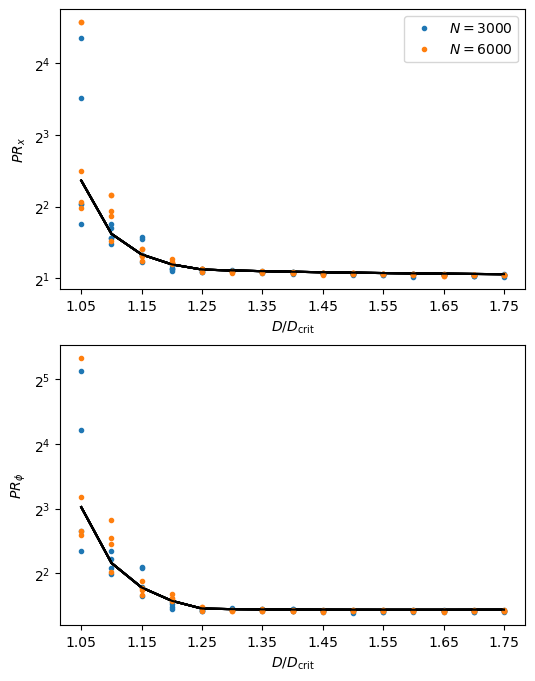

In [234]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

for i in range(2):
    ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,0,0],
             '.', alpha=1, color='C{}'.format(i))
for i in range(2):
    for i_seed in range(4):
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,0],
                 '.', alpha=1, color='C{}'.format(i))
        ax[0].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,1],
                 alpha=1, color='k')
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,2],
                 '.', alpha=1, color='C{}'.format(i))
        ax[1].plot(theory_results[0]['D_crit_factor'],theory_results[1][i,:,i_seed,3],
                 alpha=1, color='k')
#plt.yscale('log', base=2)
ax[0].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[1].set_xticks(theory_results[0]['D_crit_factor'][::2])
ax[0].set_xlabel('$D/D_\mathrm{crit}$')
ax[1].set_xlabel('$D/D_\mathrm{crit}$')
ax[0].set_ylabel('$PR_x$')
ax[1].set_ylabel('$PR_\phi$')
ax[0].legend(['$N = 3000$', '$N = 6000$'])
ax[0].set_yscale('log', base=2)
ax[1].set_yscale('log', base=2)
#ax[1].set_xscale('log', base=2)

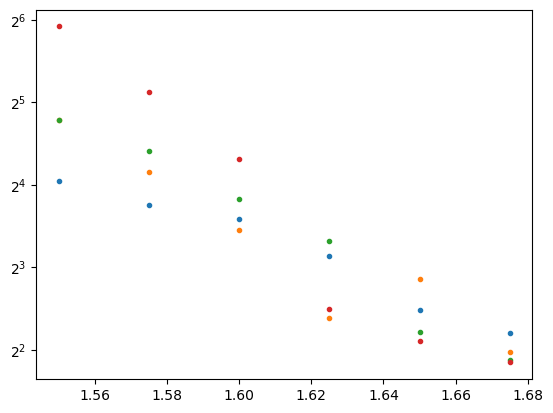

In [10]:
for i in range(4):
    plt.plot(theory_results[0]['D_1'],theory_results[1][i,:,:,0].mean(-1),
             '.', alpha=1, color='C{}'.format(i))
plt.yscale('log', base=2)

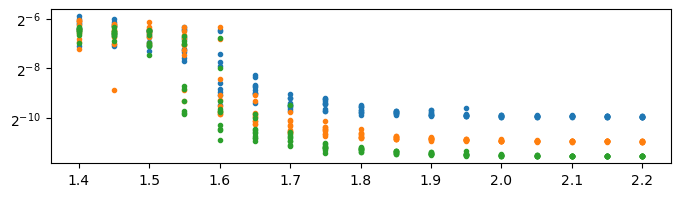

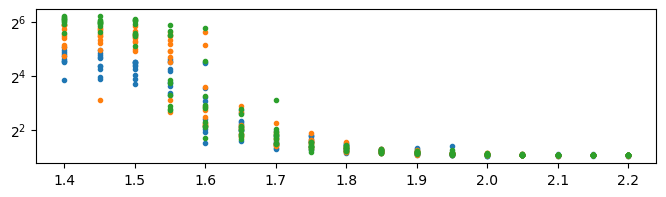

In [29]:
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    for i_seed in range(10):
        plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,i_seed,0]/N, '.', color='C{}'.format(i))
plt.yscale('log', base=2)
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    for i_seed in range(10):
        plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,i_seed,0], '.', color='C{}'.format(i))
plt.yscale('log', base=2)
#plt.yscale('log', base=2)
#plt.yticks([1, 2, 32])

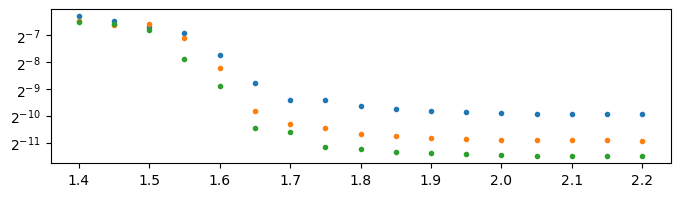

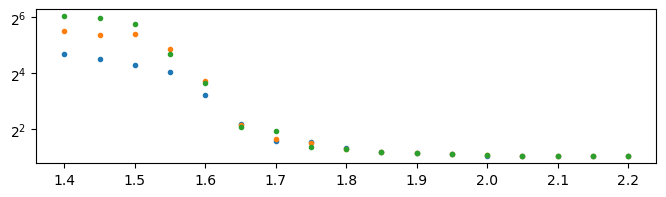

In [4]:
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,:,0].mean(1)/N, '.', color='C{}'.format(i))
plt.yscale('log', base=2)
plt.figure(figsize=(8, 2))
for i in range(3):
    N = theory_results[0]['N'][i]
    plt.plot(theory_results[0]['D_1'], theory_results[1][i,:,:,0].mean(1), '.', color='C{}'.format(i))
plt.yscale('log', base=2)
#plt.yscale('log', base=2)
#plt.yticks([1, 2, 32])

(-0.04854065701365471, 0.47105365797857557)

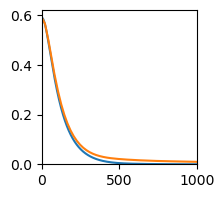

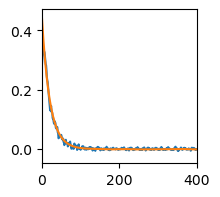

In [4]:
i_sym = 0
i_C_sigma = 0
i_PR_D = 2
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,2,:].mean(0)
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,3,:].mean(0)
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 1000])
ymax = np.amax(np.concatenate([theory, sim]))
plt.ylim([0, ymax * 1.05])
plt.figure(figsize=(2, 2))
theory = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,0,:].mean(0)
sim = theory_results[1][i_sym, i_C_sigma, i_PR_D,:,1,:].mean(0)
plt.plot(theory)
plt.plot(sim)
plt.xlim([0, 400])
ymax = np.amax(np.concatenate([theory, sim]))
ymin = np.amin(np.concatenate([theory, sim]))
plt.ylim([ymin, ymax * 1.05])

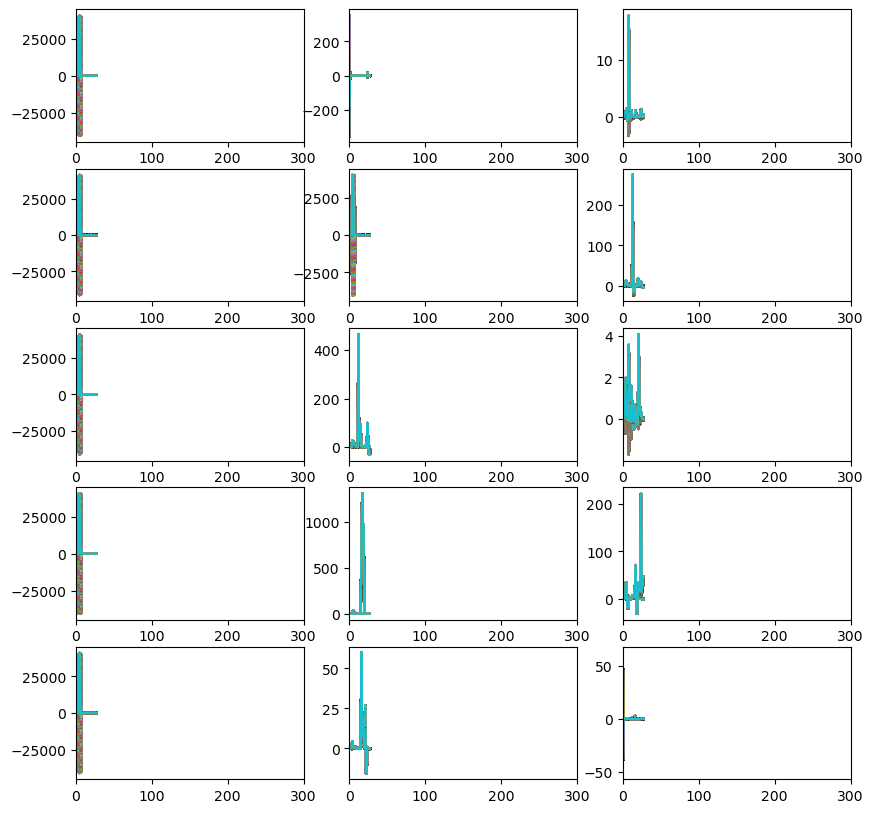

In [15]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        ax[i_sym,i_g].plot(theory_results[1][i_sym,i_g,0,0,:])
        ax[i_sym,i_g].plot(theory_results[1][i_sym,i_g,0,1,:])
        ax[i_sym,i_g].set_xlim([0, 300])

In [ ]:
theory_results[1].shape
plt.plot(theory_results[1][0,0,0,2,:])
plt.plot(theory_results[1][0,0,0,3,:])
plt.xlim([0, 1000])

In [ ]:
#network properties size
#N = theory_results[0]['N'][i_N]

def get_activity(i_g, i_sym):
    #i_g = 0
    #i_sym = 0
    N = 5000
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    g = theory_results[0]['g'][i_g]
    #g = 5
    #lags window
    T_window_emp = 1
    dT_emp = 1
    lags_emp = np.arange(0, T_window_emp, dT_emp)
    n_lags_emp = int(T_window_emp/dT_emp)

    R = 2
    #alpha = theory_results[0]['alpha'][i_alpha]
    alpha = 0.5
    N_tasks = int(alpha * N)
    PR_D = 1
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction

    sym = theory_results[0]['sym'][i_sym]
    sym = -1
    sigma_mn_all = np.zeros((R, R, N_tasks))
    total_attempts = 0
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                                     sigma_off=0.6,
                                                                                     symmetry_factor=sym,
                                                                                     traceless=False, report_attempts=True)
        total_attempts += n_attempts
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)

    ### --- Estimate S empirically --- ###

    T_sim = 400
    dt = 0.05
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
    
    return x, r, Z

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        x, r, Z = get_activity(i_g, i_sym)
        ax[i_sym, i_g].plot(x[:2000,0])
        ax[i_sym, i_g].set_ylim([-15, 15])

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i_sym in range(5):
    for i_g in range(3):
        x, r, Z = get_activity(i_g, i_sym)
        ax[i_sym, i_g].plot(Z[0,:2000,0])
        ax[i_sym, i_g].set_ylim([-15, 15])

In [46]:
###### --- Plot basic transients --- ###

i_g = 0
i_sym = 0
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 0.3
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 300
dt = 0.05
x1, r1 = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200, noise_series=None)
x0 = torch.tensor(x1[-1]).to(0)[None,:]
m1 = torch.tensor(all_loadings[0,:,0]).to(0)
n1 = torch.tensor(all_loadings[0,:,2]).to(0)
x2, r2 = sample_activity(T_sim=5, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=300*m1)
x0 = torch.tensor(x2[-1]).to(0)[None,:]
#x0 = 300*n1[None,:]
x3, r3 = sample_activity(T_sim=200, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_series=None, input_current=None)

#x = np.concatenate([x1, x3], axis=0)
#r = np.concatenate([r1, r3], axis=0)
x = np.concatenate([x1, x2, x3], axis=0)
r = np.concatenate([r1, r2, r3], axis=0)
Z = np.einsum('air, ti -> atr', all_loadings[:6, :, 2:4], r) * D[:6,None,None]

In [40]:
np.savez('packaged_results/input_drive_transients.npz', Z=Z)

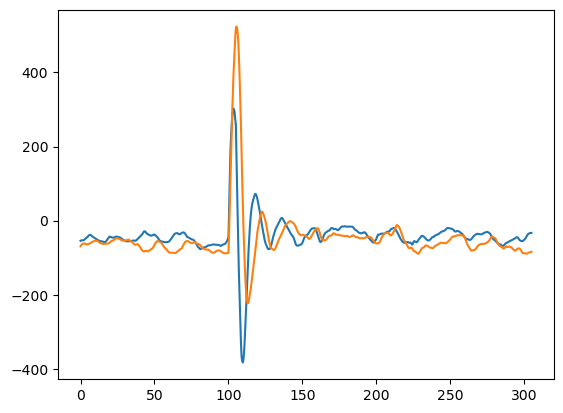

In [47]:
time_vec = np.arange(0, 305, dt)
plt.plot(time_vec, Z[0,:,0])
plt.plot(time_vec, Z[0,:,1])
#plt.xlim([50, 150])

In [75]:
### --- Plot basic transients --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 100000
dt = 0.1
x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                       runga_kutta=False, T_save_delay=200, noise_series=None)
Z = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
#plt.plot(Z[0,:,0])
#plt.plot(Z[0,:,1])

1060


In [3]:
### --- Plot basic transients --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 10000
dt = 0.1
N_runs = 50
Zs = []
for i_run in range(N_runs):
    print(i_run)
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=False, T_save_delay=10, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    Zs.append(Z)
#plt.plot(Z[0,:,0])
#plt.plot(Z[0,:,1])

958
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [10]:
import numpy as np
import matplotlib.pyplot as plt

N = 4000

def compute_average_flow_field_cartesian_batches(all_batches, n_x_bins=20, n_y_bins=20,
                                                   x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series batches.
    Each batch is treated independently so that the end of one batch and the start of the next
    do not get connected.
    
    Parameters:
      all_batches : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory for one batch.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Prepare arrays for accumulation.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define the grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    # Process each batch separately.
    for batch in all_batches:
        # Skip batches that are too short.
        if batch.shape[0] < 2:
            continue
        # Compute velocities within this batch.
        velocities = np.diff(batch, axis=0)
        # Use midpoints of consecutive points for binning.
        positions = 0.5 * (batch[:-1] + batch[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if outside region.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Determine bin indices.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute the average velocities where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None, limit_cycle=None, plot_only_first=True, fp=None, Z_long=None,
                                     z_labels=None, sqrt_ticks=True, plot_arrows=False):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # For streamplot, provide 1D coordinate arrays and transpose U and V.
    fig = plt.figure(figsize=(5, 5))
    if Z is not None:
        for z in Z:
            plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=1, linewidth=1, zorder=2)
            if plot_arrows:
                # Compute directional differences between successive points
                dx = np.diff(z[:, 0])
                dy = np.diff(z[:, 1])
                speed = np.sqrt(dx**2 + dy**2)
                dx = dx/speed
                dy = dy/speed

                # Choose arrow placement interval (adjust based on your data density)
                arrow_interval = max(1, len(z) // 20)

                # Plot arrows using quiver. We use z[:-1] since np.diff returns one fewer element.
                plt.quiver(z[:-1:arrow_interval, 0], z[:-1:arrow_interval, 1],
                           dx[::arrow_interval], dy[::arrow_interval],
                           color='#AC85BC', scale_units='xy', angles='xy', scale=0.8,
                            width=0.008,         # Arrow shaft thickness
                            headwidth=15,         # Width of the arrow head
                            headlength=15,        # Length of the arrow head
                            headaxislength=15, zorder=3)

            
            if plot_only_first:
                break
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density,
                   color=speed, cmap='Greys', linewidth=linewidth, arrowsize=arrowsize)

    if limit_cycle is not None:
        plt.plot(limit_cycle[:,0], limit_cycle[:,1], color='k', linestyle='--', linewidth=0.8)
    if fp is not None:
        for fp_ in fp:
            plt.plot([fp_[0]], [fp_[1]], 'x', color='k', markersize=3)
    if Z_long is not None:
        plt.plot(Z_long[:,0], Z_long[:,1], color='#AC85BC', linewidth=0.7)
    if z_labels==1:
        plt.xlabel('$z^{(1)}_1(t)$', fontsize=8)
        plt.ylabel('$z^{(1)}_2(t)$', fontsize=8)
    elif z_labels==2:
        plt.xlabel('$z^{(2)}_1(t)$', fontsize=8)
        plt.ylabel('$z^{(2)}_2(t)$', fontsize=8)
    else:
        plt.xlabel('$z_1(t)$', fontsize=8)
        plt.ylabel('$z_2(t)$', fontsize=8)
    #plt.title('Average Flow Field (Cartesian Grid, Batches)')
    if sqrt_ticks:
        plt.xticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=8)
        plt.yticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=8)
    else:
        pass
    plt.axis('equal')
    plt.show()
    
    return fig

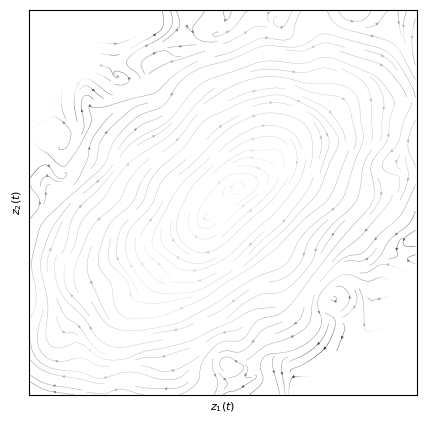

In [11]:
R = 15
x_range = (-R, R)
y_range = (-R, R)

all_batches = [zs[1] for zs in Zs]

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
fig = plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=0.3, arrowsize=0.4,
                                       Z=None, plot_only_first=False)

In [4]:
all_batches = Z[None,:0,:,:]

R = 2
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                 Z=None, Z_long=None)

NameError: name 'compute_average_flow_field_cartesian_batches' is not defined

In [76]:
np.savez('packaged_results/MalphaN_limcyc_fp_2', Z=Z)

In [77]:
!du -sh packaged_results/MalphaN_limcyc_fp.npz

10M	packaged_results/MalphaN_limcyc_fp.npz


In [14]:
### --- M = 1 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.55, 0.4],[0.4, 0.55]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_[0])
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

0


In [15]:
np.savez('packaged_results/M=1_network_3', Zs=Zs, Z_long=Z_long)

In [55]:
### --- M = 2 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 2
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 40
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0_1 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0_2 = torch.tensor(all_loadings[1,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x0 = x0_1 + x0_2
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long2 = np.einsum('air, ti -> atr', all_loadings[:2, :, 2:4], r) * D[:2,None,None]

2


In [57]:
np.savez('packaged_results/M=2_network_limcyc_fp', Zs=Zs, Z_long=Z_long, Z_long2=Z_long2)

In [58]:
### --- M = 1 network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
#N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
#D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,0] = np.array([[0.5, 0.3],[0.3, 0.5]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_)
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=0, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

1


In [59]:
np.savez('packaged_results/M=1_network_fp', Zs=Zs, Z_long=Z_long)

In [ ]:
### --- M = \alpha N network --- ###

#i_g = 0
#i_sym = 0
N = 4000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
#alpha = 0.5
#N_tasks = int(alpha * N)
N_tasks = 1
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D = D * 2 / D[0]

#sym = theory_results[0]['sym'][i_sym]
sym = 0
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
C_sigma = 0.5
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=C_sigma,
                                                                                 sigma_off=C_sigma,
                                                                                 symmetry_factor=sym,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, 0.4],[-0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.55, 0.4],[0.4, 0.55]])
D[0] = D[0] * 1
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
T_sim = 20
dt = 0.05
N_runs = 1000
#Z = np.zeros((1,int(T_sim/dt)*N_runs, 2))
Zs = []
for i_run in range(N_runs):
    if i_run > 500:
        ic_std = 50
    else:
        ic_std = 10
#     if i_run == 0:
#         T_sim = 20
#     else:
#         T_sim = 10
    x0 = torch.tensor(all_loadings[0,:,2:4].dot(np.random.normal(0, ic_std, 2))).to(torch.float).to(0)[None,:]
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=False, T_save_delay=0, noise_series=None)
    Z_ = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]
    #Z[:,i_run * int(T_sim/dt): (i_run + 1)*int(T_sim/dt), :] = Z_
    #if i_run > 0:
        #from pdb import set_trace
        #set_trace()
    #    Z_ = np.concatenate([Z_, np.array([np.nan]*int(2*T_sim/dt)).reshape(-1, 2)[None,:,:]], axis=1)
    Zs.append(Z_[0])
#single long run for plotting line attractor
Zs = np.array(Zs)
x, r = sample_activity(T_sim=120, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=None,
                       runga_kutta=False, T_save_delay=100, noise_series=None)
Z_long = np.einsum('air, ti -> atr', all_loadings[:1, :, 2:4], r) * D[:1,None,None]

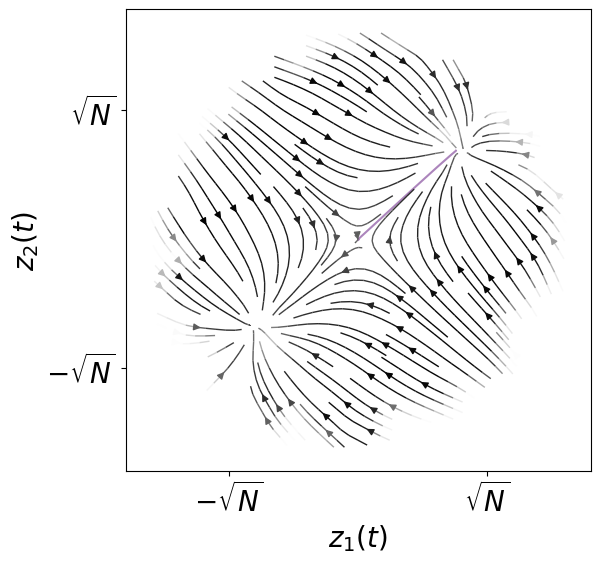

In [52]:
all_batches = Zs[:,0,:,:]

R = 120
x_range = (-R, R)
y_range = (-R, R)

# Compute the flow field for the distinct batches.
avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
    all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)

# Plot the flow field using a streamplot.
plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                 Z=None, Z_long=Z_long[0])

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_flow_field_cartesian_batches(all_batches, n_x_bins=20, n_y_bins=20,
                                                   x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series batches.
    Each batch is treated independently so that the end of one batch and the start of the next
    do not get connected.
    
    Parameters:
      all_batches : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory for one batch.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Prepare arrays for accumulation.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define the grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    # Process each batch separately.
    for batch in all_batches:
        # Skip batches that are too short.
        if batch.shape[0] < 2:
            continue
        # Compute velocities within this batch.
        velocities = np.diff(batch, axis=0)
        # Use midpoints of consecutive points for binning.
        positions = 0.5 * (batch[:-1] + batch[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if outside region.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Determine bin indices.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute the average velocities where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None, Z_long=None):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # For streamplot, provide 1D coordinate arrays and transpose U and V.
    plt.figure(figsize=(6, 6))
    if Z is not None:
        for z in Z:
            plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=0.3)
            #plt.plot(z[:,0], z[:,1], color='#AC85BC', alpha=1, linewidth=1.5)
            #break
    if Z_long is not None:
        plt.plot(Z_long[:,0], Z_long[:,1], color='#AC85BC', linewidth=1.5)
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density,
                   color=speed, cmap='Greys', linewidth=linewidth, arrowsize=arrowsize)

    plt.xlabel('$z_1(t)$', fontsize=20)
    plt.ylabel('$z_2(t)$', fontsize=20)
    #plt.title('Average Flow Field (Cartesian Grid, Batches)')
    plt.xticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=20)
    plt.yticks([-np.sqrt(N), np.sqrt(N)], ['$-\sqrt{N}$', '$\sqrt{N}$'], fontsize=20)
    plt.axis('equal')
    plt.show()

# Example usage
if __name__ == '__main__':

    all_batches = Zs[:,1,:,:]
    
    R = 120
    x_range = (-R, R)
    y_range = (-R, R)
    
    # Compute the flow field for the distinct batches.
    avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian_batches(
        all_batches, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)
    
    # Plot the flow field using a streamplot.
    plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=Zs[:,1,:,:], Z_long=Z_long2[1])


IndexError: index 1 is out of bounds for axis 1 with size 1

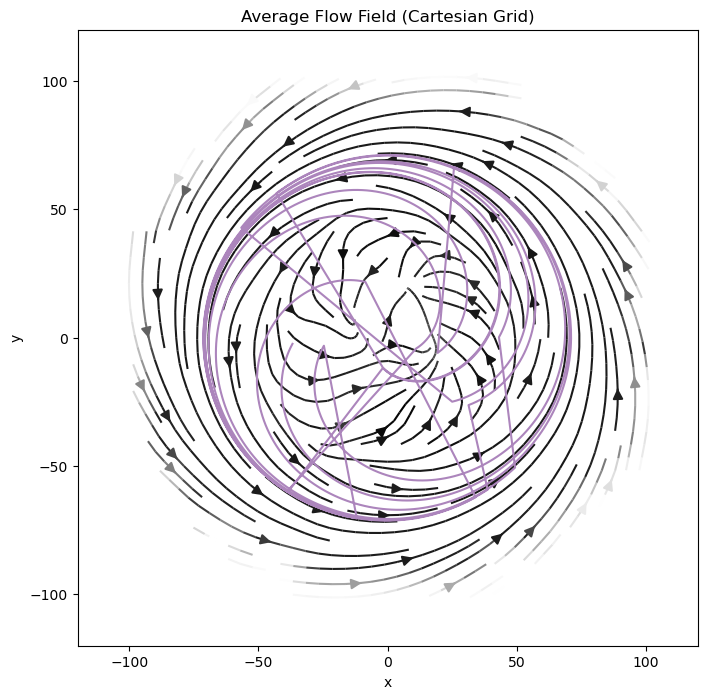

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def compute_average_flow_field_cartesian(all_series, n_x_bins=20, n_y_bins=20, x_range=(-2.0, 2.0), y_range=(-2.0, 2.0)):
    """
    Computes the average flow field over a Cartesian grid from a list of time series.

    Parameters:
      all_series : list of np.ndarray
          Each array is of shape (T, 2) representing a 2D trajectory.
      n_x_bins : int
          Number of bins in the x direction.
      n_y_bins : int
          Number of bins in the y direction.
      x_range : tuple (x_min, x_max)
          Range in the x direction.
      y_range : tuple (y_min, y_max)
          Range in the y direction.
          
    Returns:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      counts : np.ndarray, shape (n_x_bins, n_y_bins)
          Number of velocity samples in each cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
    """
    # Create arrays to accumulate velocity sums and counts.
    velocity_sum = np.zeros((n_x_bins, n_y_bins, 2))
    counts = np.zeros((n_x_bins, n_y_bins))
    
    # Define grid edges.
    x_edges = np.linspace(x_range[0], x_range[1], n_x_bins + 1)
    y_edges = np.linspace(y_range[0], y_range[1], n_y_bins + 1)
    
    for series in all_series:
        # Compute finite-difference velocities.
        velocities = np.diff(series, axis=0)
        # Compute midpoints between consecutive points.
        positions = 0.5 * (series[:-1] + series[1:])
        
        for pos, vel in zip(positions, velocities):
            x, y = pos
            # Skip if the position is out of the defined range.
            if (x < x_range[0]) or (x > x_range[1]) or (y < y_range[0]) or (y > y_range[1]):
                continue
            # Find the corresponding bin indices for x and y.
            x_bin = int(np.floor((x - x_range[0]) / (x_range[1] - x_range[0]) * n_x_bins))
            y_bin = int(np.floor((y - y_range[0]) / (y_range[1] - y_range[0]) * n_y_bins))
            # Handle edge cases where position equals the upper bound.
            if x_bin == n_x_bins:
                x_bin = n_x_bins - 1
            if y_bin == n_y_bins:
                y_bin = n_y_bins - 1
            # Accumulate velocity and count.
            velocity_sum[x_bin, y_bin] += vel
            counts[x_bin, y_bin] += 1
    
    # Compute average velocity where counts > 0.
    avg_flow = np.zeros_like(velocity_sum)
    mask = counts > 0
    avg_flow[mask] = velocity_sum[mask] / counts[mask, None]
    
    return avg_flow, counts, x_edges, y_edges

def plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1, arrowsize=1,
                                     Z=None):
    """
    Plots the average flow field on a Cartesian grid using streamplot.
    
    Parameters:
      avg_flow : np.ndarray, shape (n_x_bins, n_y_bins, 2)
          The average velocity vector in each grid cell.
      x_edges, y_edges : np.ndarray
          The bin edges for x and y.
      density : float
          Controls the closeness of streamlines.
      linewidth : float
          Line width of the streamlines.
      arrowsize : float
          Size of the arrows.
    """
    # Compute bin centers from the edges.
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    
    # Extract averaged velocity components.
    U = avg_flow[:, :, 0]
    V = avg_flow[:, :, 1]
    
    # Note: When providing 1D coordinate arrays, U and V need shape (len(y_centers), len(x_centers)).
    # Our U and V are of shape (n_x_bins, n_y_bins), so we transpose them.
    plt.figure(figsize=(8, 8))
    speed = np.log10(np.sqrt(U**2 + V**2) + 0.001)
    plt.streamplot(x_centers, y_centers, U.T, V.T, density=density, color=speed,
                   linewidth=linewidth, arrowsize=arrowsize, cmap='Greys')
    if Z is not None:
        plt.plot(Z[:,0], Z[:,1], color='#AC85BC')
    plt.xlim([np.amin(x_edges), np.amax(x_edges)])
    plt.ylim([np.amin(y_edges), np.amax(y_edges)])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Average Flow Field (Cartesian Grid)')
    #plt.axis('equal')
    plt.show()

# Example usage
if __name__ == '__main__':
    
    all_series = [Z[0]]
    # Define Cartesian region of interest.
    R = 120
    x_range = (-R, R)
    y_range = (-R, R)
    
    # Compute the average flow field on the Cartesian grid.
    avg_flow, counts, x_edges, y_edges = compute_average_flow_field_cartesian(
        all_series, n_x_bins=20, n_y_bins=20, x_range=x_range, y_range=y_range)
    
    # Plot the estimated flow field using streamplot.
    plot_flow_field_cartesian_stream(avg_flow, x_edges, y_edges, density=1.5, linewidth=1.5, arrowsize=1.5,
                                     Z=Z[0,:2000])
    #plt.colorbar()

In [ ]:
#smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][i_sigma_off, i_seed, 0, :], dtype=torch.float32).to(0)
C = torch.tensor(theory_results[1][i_sigma_off, i_seed, 2, :], dtype=torch.float32).to(0)
N_t = C.shape[0]
#T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)
C_w = uni_rfft(C, dt)

In [ ]:
Crr = np.array([[0.8, -0.4],[0.4, 0.8]])
#Crr = Crr
#Crr = Crr.T
#T = len(C_phi)
#t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
#sampfreq = 1/dT
#w = 2*np.pi*sampfreq*t_indices/T
S_omega = np.sqrt(2*np.pi)*S_.cpu().numpy()[:,None,None]
M_inv = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr[None,:,:]*S_omega)
M_invT = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr.T[None,:,:]*S_omega.conj())
z_ccov = np.zeros_like(M_inv)
for w in range(z_ccov.shape[0]):
    z_ccov[w] = D[0]**2 * M_inv[w,:,:].dot(M_invT[w,:,:]) * C_w[w].cpu().numpy()
z_ccov_w = torch.from_numpy(z_ccov).to(0)
z_ccov_T = uni_irfft(z_ccov_w, 0.05, axis=0)
#z_ccov_T = z_ccov_T.cpu().numpy()

In [ ]:
z_ccov_avg = theory_results[1][i_sigma_off, i_seed, :, :].T
T = z_ccov_T.shape[0]

i_task = 0
acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])

In [ ]:
acov_T_11.shape

In [ ]:
fig, ax = plt.subplots(2, 2)
time_vec = np.arange(-len(acov_avg_11)*dt/2, len(acov_avg_11)*dt/2, dt)
ax[0,0].plot(time_vec, acov_T_11, color='C0')
ax[0,0].plot(time_vec, acov_avg_11, color='k', linestyle='--')
ax[1,1].plot(time_vec, acov_T_22, color='C0')
ax[1,1].plot(time_vec, acov_avg_22, color='k', linestyle='--')
ax[0,1].plot(time_vec, ccov_T_12, color='C0')
ax[0,1].plot(time_vec, ccov_avg_21, color='k', linestyle='--')
ax[1,0].plot(time_vec, ccov_T_21, color='C0')
ax[1,0].plot(time_vec, ccov_avg_12, color='k', linestyle='--')
ax[0,0].set_title(r'$C^z_{11}(\tau)$')
ax[0,1].set_title(r'$C^z_{12}(\tau)$')
ax[1,0].set_title(r'$C^z_{21}(\tau)$')
ax[1,1].set_title(r'$C^z_{22}(\tau)$')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$')
ax[0,0].legend(['sim', 'theory'])
plt.tight_layout()
fig.savefig('figs/cross_cov_fits.pdf')